In [61]:
%load_ext watermark
%watermark -a Filippo_Valle -p numpy,pandas,seaborn,matplotlib,topicpy,sklearn,cloudpickle,plotly,nsbm -m -g -r -v

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Filippo_Valle

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.25.0

numpy      : 1.19.5
pandas     : 1.2.5
seaborn    : 0.11.1
matplotlib : 3.4.2
topicpy    : 0.2.1
sklearn    : 0.0
cloudpickle: 1.6.0
plotly     : 5.1.0
nsbm       : 0.4.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.11.0-22-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Git hash: 72b2a7229fdaf97deb8ecbd5096271f776a83435

Git repo: git@github.com:fvalle1/keywordTCGA.git



In [88]:
import os
import numpy as np
import pandas as pd
import seaborn as  sns
import matplotlib.pyplot as plt
from topicpy.hsbmpy import get_scores, get_scores_shuffled, normalise_score, add_score_lines, get_max_available_L
from topicpy.hsbmpy import get_cluster_given_l, get_fraction_sites, get_clustersinfo, plot_cluster_composition

# Clustering and scores

In [89]:
level = 1
algorithm = 'trisbm'
directory = "brca/"
L=get_max_available_L(directory, algorithm)
df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,L), header=[0])
df_clusters.head()

,Cluster 1
0,TCGA-Z7-A8R6
1,TCGA-AO-A126
2,TCGA-AO-A0JI
3,TCGA-AO-A0JJ
4,TCGA-AO-A0JL


In [90]:
df_files = pd.read_csv("%s/files.dat"%directory, index_col=[0], header=[0]).dropna(axis=1, how='all').dropna(axis=0, how='all')
samples = pd.read_csv("%s/%s/%s_level_0_clusters.csv"%(directory,algorithm,algorithm), header=[0]).astype(str).values.ravel()
samples=samples[samples!="nan"]
df_files = df_files.reindex(index=samples).dropna(how="any",axis=0).fillna("unknown")
labels = df_files.columns
print(labels)

Index(['file_miRNA', 'cases.0.demographic.days_to_birth',
       'cases.0.demographic.days_to_death', 'cases.0.demographic.gender',
       'cases.0.demographic.vital_status',
       'cases.0.diagnoses.0.age_at_diagnosis',
       'cases.0.diagnoses.0.days_to_last_follow_up',
       'cases.0.diagnoses.0.last_known_disease_status',
       'cases.0.diagnoses.0.tumor_stage', 'cases.0.project.project_id',
       'sample_submitter_id_mirna', 'file_fpkm',
       'cases.0.demographic.days_to_birth.1',
       'cases.0.demographic.days_to_death.1', 'cases.0.demographic.gender.1',
       'cases.0.demographic.vital_status.1',
       'cases.0.diagnoses.0.age_at_diagnosis.1',
       'cases.0.diagnoses.0.days_to_last_follow_up.1',
       'cases.0.diagnoses.0.last_known_disease_status.1',
       'cases.0.diagnoses.0.tumor_stage.1', 'cases.0.project.project_id.1',
       'sample_submitter_id', 'sample_submitter_id_type',
       'sample_submitter_id_mirna_type', 'cancer.type', 'Subtype_mRNA',
       'Sub

In [97]:
analyses = {
    "normaltumor": ["hsbm", "trisbm", "shuffle"],
    "subtypes": ["hsbm", "trisbm", "shuffle"],
    "regulatory": ["hsbm", "trisbm", "mirdip", "tarbase", "shuffle"]
}

In [92]:
labels = ["Subtype_Selected", 'sample_submitter_id_type', 'sample_submitter_id_mirna_type']

In [95]:
directory = "brca/"

scores = {}
scores['hsbm'] = get_scores(directory, labels, algorithm='topsbm', df_files=df_files, verbose=False)[labels[1]]
scores['trisbm'] = get_scores(directory, labels, algorithm='trisbm', df_files=df_files, verbose=False)[labels[1]]
#scores['tetrasbm'] = get_scores(directory+"/tetrasbm/", labels, algorithm='trisbm', df_files=df_files, verbose=False)[labels[1]]
#scores['pentasbm'] = get_scores(directory+"/pentasbm/", labels, algorithm='trisbm', df_files=df_files, verbose=False)[labels[1]]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=labels[0], algorithm='topsbm')
shuffle = []
for _ in range(5):
    shuffle.append(get_scores_shuffled(directory, df_files, label=labels[0], algorithm='topsbm')["V"])
scores["shuffle"]["V"] = np.average(shuffle,0)
normalise_score(scores, base_algorithm="shuffle")

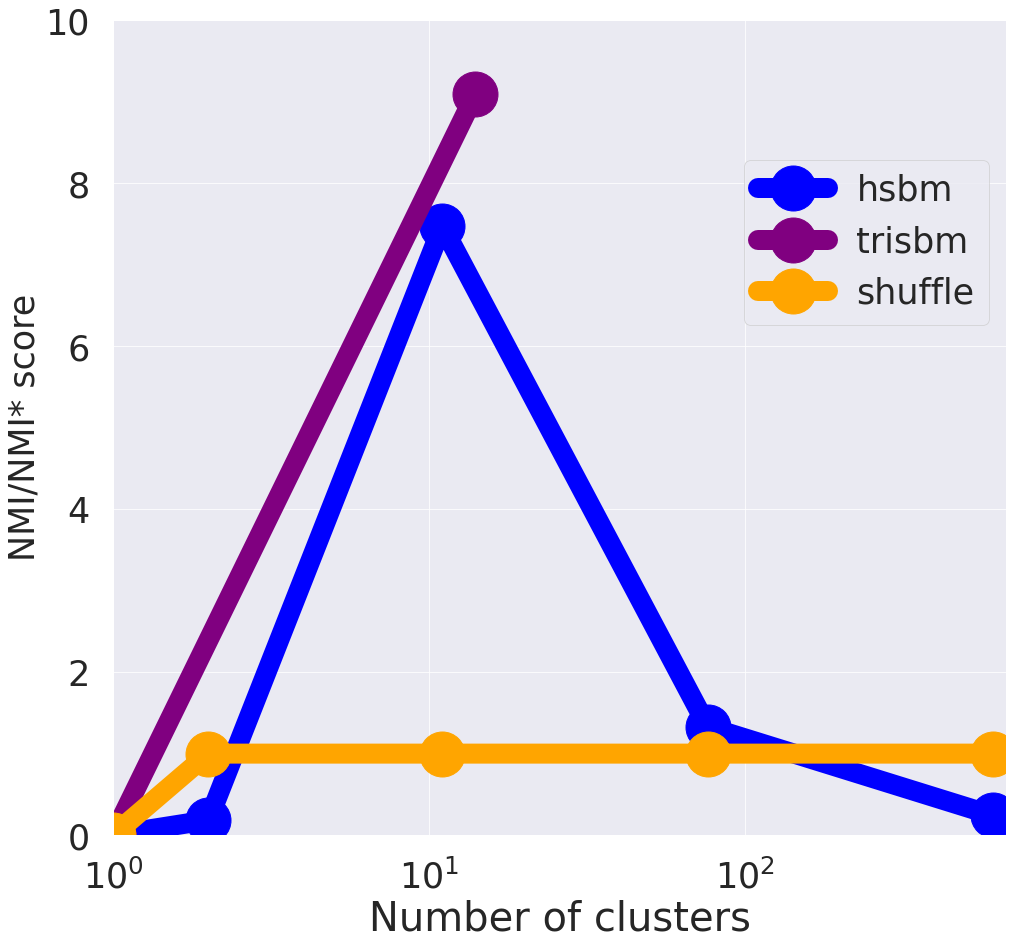

In [98]:
analysis = "normaltumor"

fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax,scores, V="norm_V", labels=analyses[analysis])
#ax.set_xscale('linear')
#ax.set_title("Tumor/Normal", fontsize=40)
ax.set_ylabel("NMI/NMI* score", fontsize=35)

plt.xlim(1,max(map(max,[score["xl"] for score in scores.values()]))*1.1)
plt.ylim(0,max(map(max,[score["norm_V"] for score in scores.values()]))*1.1)
plt.show()
fig.savefig("%s/metric_scores_%s.pdf"%(directory,analysis))

In [37]:
directory = "brca_subtypes/"

scores = {}
scores['hsbm'] = get_scores("../cancers/breast/", ["Subtype_Selected"], algorithm='topsbm', df_files=pd.read_csv("../cancers/breast/files.dat", index_col=0), verbose=False)["Subtype_Selected"]
scores['trisbm'] = get_scores(directory, labels, algorithm='trisbm', df_files=df_files, verbose=False)[labels[0]]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=labels[0], algorithm='topsbm')
shuffle = []
for _ in range(50):
    shuffle.append(get_scores_shuffled(directory, df_files, label=labels[0], algorithm='topsbm')["V"])
scores["shuffle"]["V"] = np.average(shuffle,0)
normalise_score(scores, base_algorithm="shuffle")

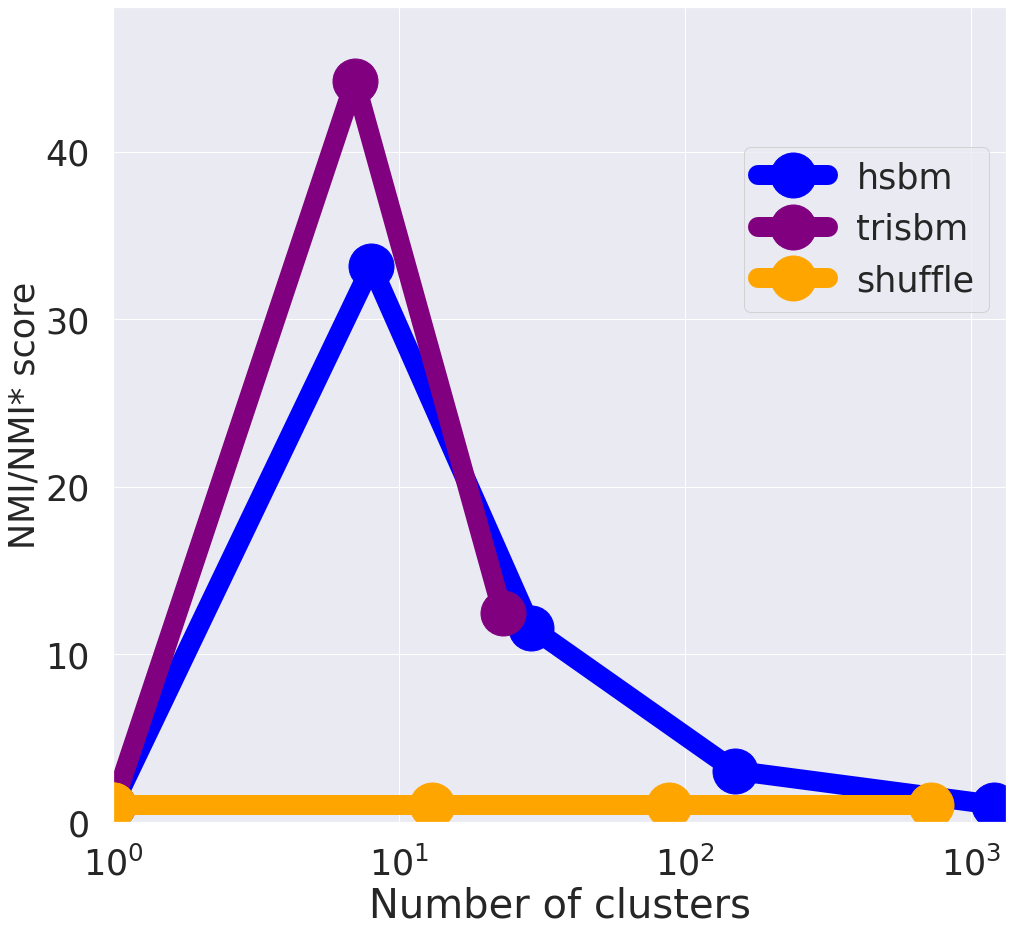

In [38]:
analysis = "subtypes"

fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax,scores, V="norm_V", labels=analyses[analysis])
#ax.set_xscale('linear')
#ax.set_title("Tumor/Normal", fontsize=40)
ax.set_ylabel("NMI/NMI* score", fontsize=35)

plt.xlim(1,max(map(max,[score["xl"] for score in scores.values()]))*1.1)
plt.ylim(0,max(map(max,[score["norm_V"] for score in scores.values()]))*1.1)
plt.show()
fig.savefig("%s/metric_scores_%s.pdf"%(directory,analysis))

/home/jovyan/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jovyan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


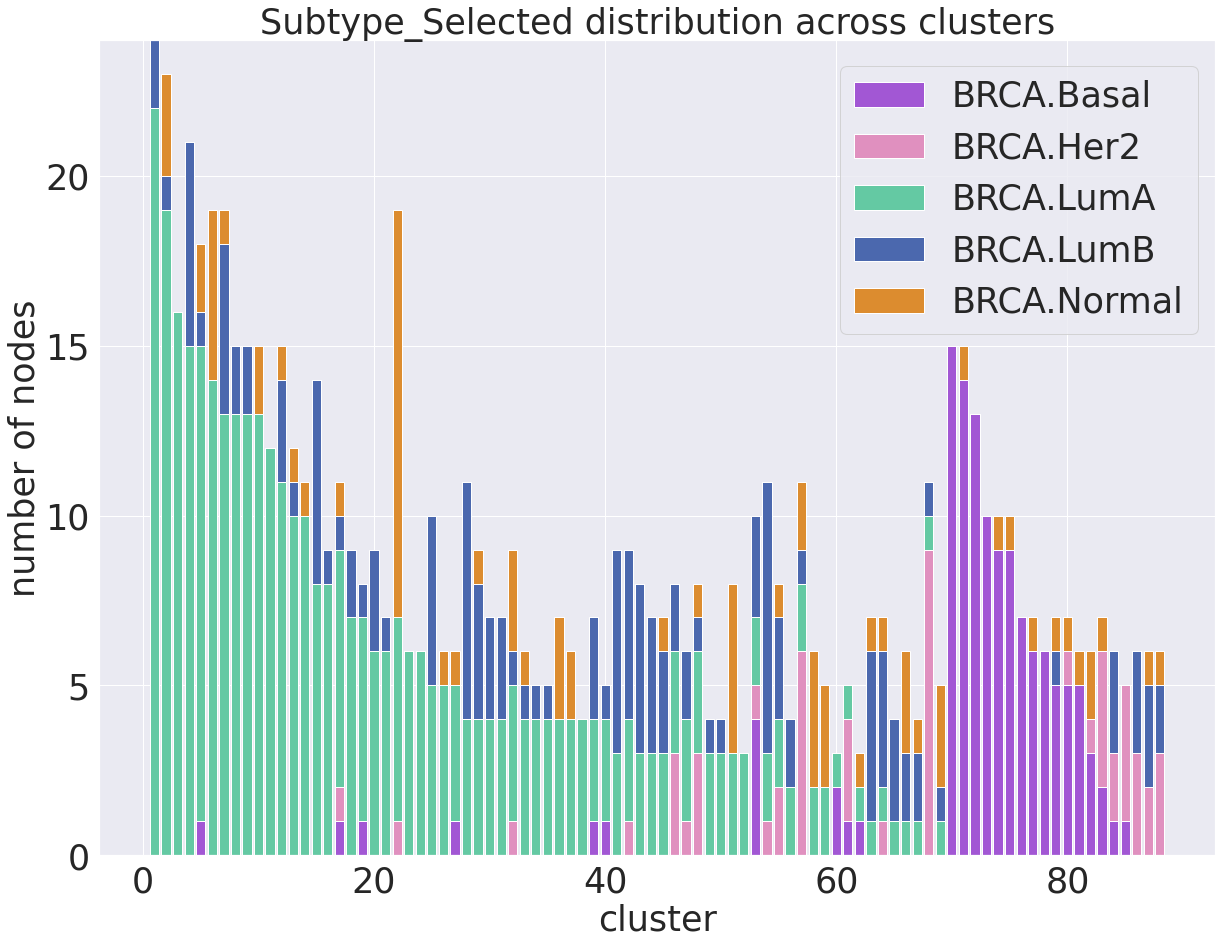

In [42]:
level = 1
algorithm = "topsbm"
cluster = get_cluster_given_l(level, directory,algorithm=algorithm)
fraction_sites = get_fraction_sites(cluster,df_files=df_files,label=labels[0], normalise=False)

clustersinfo = get_clustersinfo(cluster,fraction_sites)
plot_cluster_composition(fraction_sites,directory,level,label=labels[0], normalise=False,algorithm=algorithm)

/home/jovyan/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jovyan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


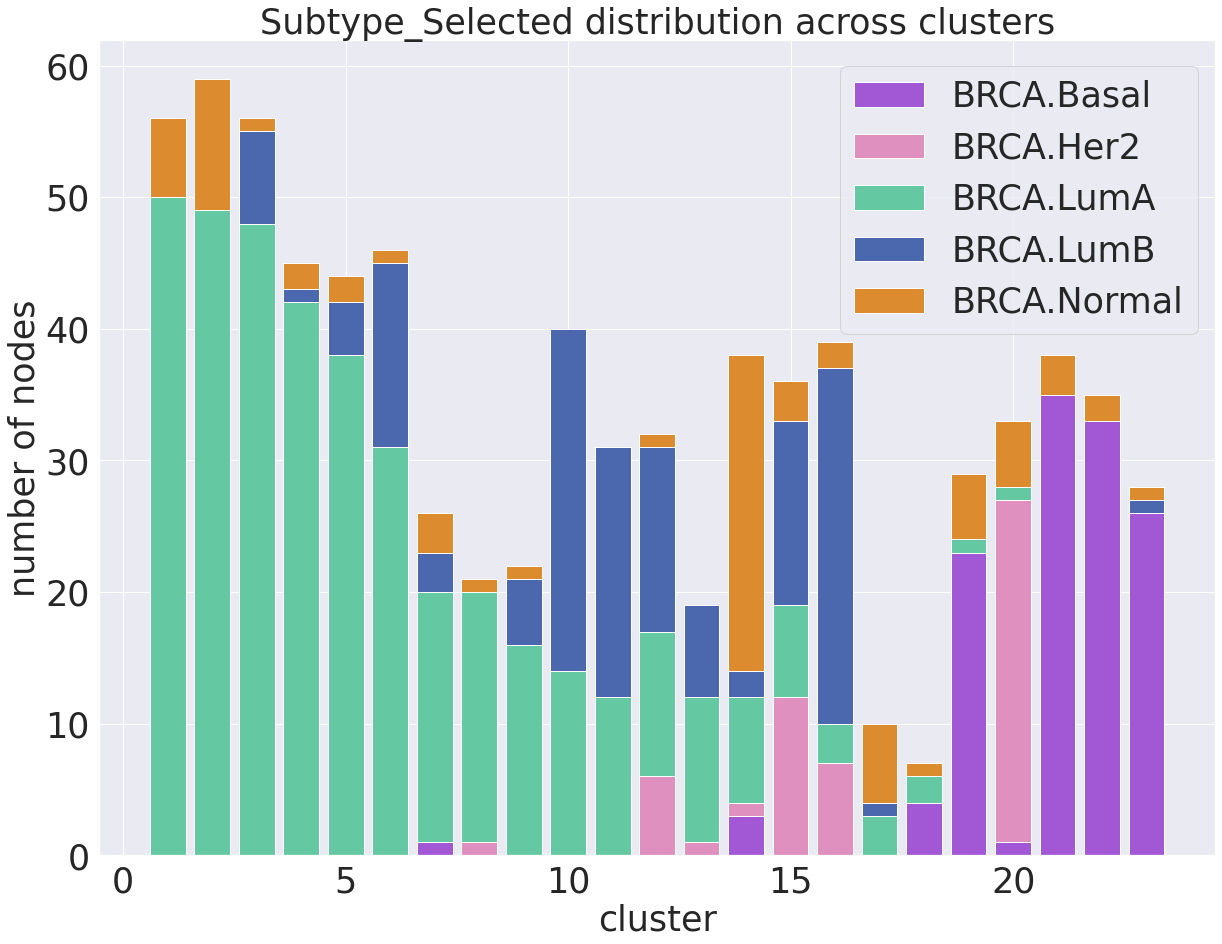

In [28]:
level = 0
algorithm = "trisbm"
cluster = get_cluster_given_l(level, directory,algorithm=algorithm)
fraction_sites = get_fraction_sites(cluster,df_files=df_files,label=labels[0], normalise=False)

clustersinfo = get_clustersinfo(cluster,fraction_sites)
plot_cluster_composition(fraction_sites,directory,level,label=labels[0], normalise=False,algorithm=algorithm)

In [11]:
directory = "brca/"

scores = {}
scores['hsbm'] = get_scores(directory, labels, algorithm='topsbm', df_files=df_files, verbose=False)[labels[0]]
scores['trisbm'] = get_scores(directory, labels, algorithm='trisbm', df_files=df_files, verbose=False)[labels[0]]
scores['tetrasbm'] = get_scores(directory+"tetrasbm", labels, algorithm='trisbm', df_files=df_files, verbose=False)[labels[0]]
scores['pentasbm'] = get_scores(directory+"pentasbm", labels, algorithm='trisbm', df_files=df_files, verbose=False)[labels[0]]
scores['mirdip'] = get_scores(directory+"/mirdip", labels, algorithm='trisbm', df_files=df_files, verbose=False)[labels[0]]
scores['tarbase'] = get_scores(directory+"/tarbase", labels, algorithm='trisbm', df_files=df_files, verbose=False)[labels[0]]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=labels[0], algorithm='topsbm')
shuffle = []
for _ in range(50):
    shuffle.append(get_scores_shuffled(directory, df_files, label=labels[0], algorithm='topsbm')["V"])
scores["shuffle"]["V"] = np.average(shuffle,0)
normalise_score(scores, base_algorithm="shuffle")

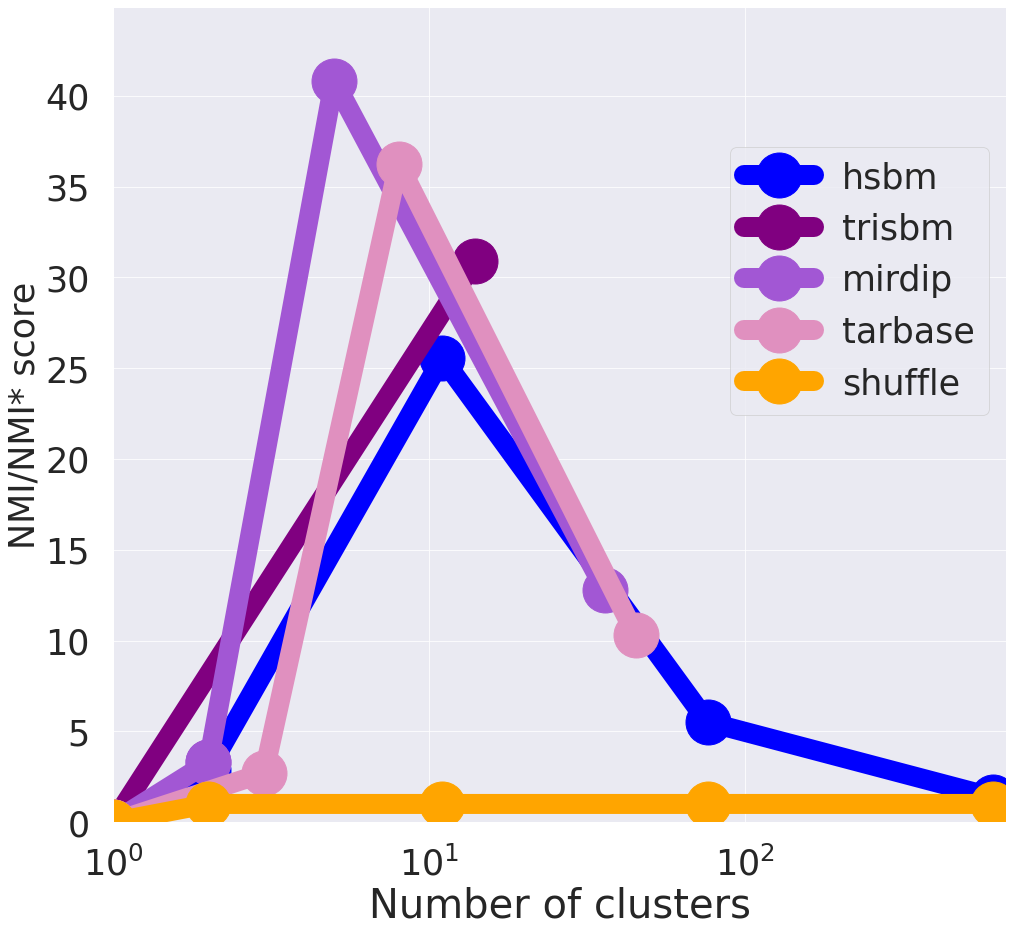

In [12]:
analysis = "regulatory"

fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax,scores, V="norm_V", labels=analyses[analysis])
#ax.set_xscale('linear')
#ax.set_title("Tumor/Normal", fontsize=40)
ax.set_ylabel("NMI/NMI* score", fontsize=35)

plt.xlim(1,max(map(max,[score["xl"] for score in scores.values()]))*1.1)
plt.ylim(0,max(map(max,[score["norm_V"] for score in scores.values()]))*1.1)
plt.show()
fig.savefig("%s/metric_scores_%s.pdf"%(directory,analysis))

In [41]:
import sys
sys.path.append("../hSBM_Topicmodel/")
from sbmtm import sbmtm
from nsbm import nsbm
import cloudpickle as pickle
import plotly.graph_objects as go

In [86]:
with open("brca_subtypes/topsbm/topsbm.pkl", "rb") as file:
    hsbm_sub = pickle.load(file)
    
with open("brca_subtypes/trisbm/model.pkl", "rb") as file:
    trisbm_sub = pickle.load(file)
    
with open("brca/trisbm/model.pkl", "rb") as file:
    tri = pickle.load(file)
    
with open("brca/tetrasbm/trisbm/trisbm.pkl", "rb") as file:
    tetrasbm = pickle.load(file)
    
with open("brca/pentasbm/trisbm/trisbm.pkl", "rb") as file:
    pentasbm = pickle.load(file)

with open("brca/tarbase/trisbm/trisbm.pkl", "rb") as file:
    tarbase = pickle.load(file)
    
#with open("brca/mirdip/trisbm/trisbm.pkl", "rb") as file:
#    mirdip = pickle.load(file)

/opt/conda/lib/python3.8/site-packages/graph_tool/inference/blockmodel.py:387: UserWarning:

unrecognized keyword arguments: ['sampling']



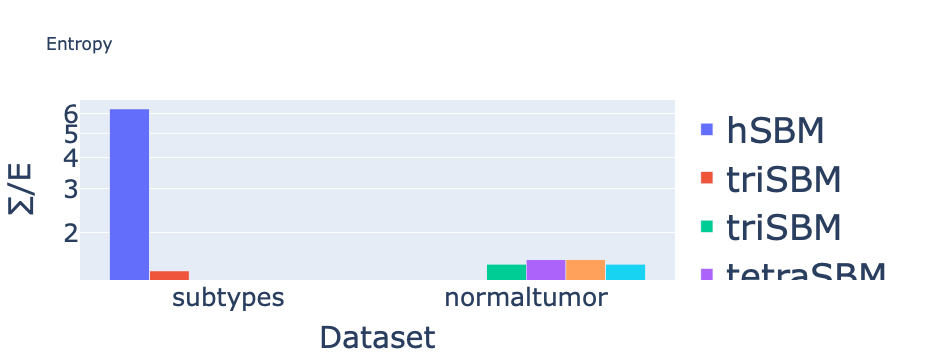

In [87]:
fig = go.Figure()

        
fig.add_traces([
    go.Bar(x=[0], y=[hsbm_sub.get_mdl()/hsbm_sub.g.num_edges()], name="hSBM"),
    go.Bar(x=[0], y=[trisbm_sub.get_mdl()/trisbm_sub.g.num_edges()], name="triSBM"),
    go.Bar(x=[1], y=[tri.get_mdl()/tri.g.num_edges()], name="triSBM"),
    go.Bar(x=[1], y=[tetrasbm.get_mdl()/tetrasbm.g.num_edges()], name="tetraSBM"),
    go.Bar(x=[1], y=[pentasbm.get_mdl()/pentasbm.g.num_edges()], name="pentaSBM"),
    go.Bar(x=[1], y=[tarbase.get_mdl()/tarbase.g.num_edges()], name="regulatory"),
    #go.Bar(x=[1], y=[mirdip.get_mdl()/mirdip.g.num_edges()], name="mirdip"),
])

titlefont = {
    "size": 30 
}

tickfont = {
    "size":25
}

layout = {
    "title":"Entropy",
    "xaxis":{
        "title": "Dataset",
        "tickmode": "array",
        "tickvals": list(range(2)),
        "ticktext": ["subtypes", "normaltumor"],
        "titlefont": titlefont,
        "tickfont": tickfont
    },
    "yaxis":{
        "title": "∑/E",
        #"range":[-3e4,1000],
        "type":"log",
        "titlefont": titlefont,
        "tickfont": tickfont,
    },
    "legend":{
        "font_size":35
    }
}

fig.update_layout(layout)

fig.show()
fig.write_image("entropy_comparison.pdf", engine="kaleido")

In [82]:
print((hsbm_sub.get_mdl()/hsbm_sub.g.num_edges()-trisbm_sub.get_mdl()/trisbm_sub.g.num_edges())*math.log10(math.exp(1)))

2.109622320663532


# Overlaps

In [65]:
directory = "brca/"
os.chdir(directory)

## Clusters conservation

In [59]:
from sklearn.metrics import adjusted_mutual_info_score

In [66]:
df_first = pd.read_csv("topsbm/topsbm_level_1_clusters.csv")
df_second = pd.read_csv("trisbm/trisbm_level_0_clusters.csv")
assert(np.isin(list(filter(lambda sample: str(sample)!="nan",df_first.values.ravel())), 
        list(filter(lambda sample: str(sample)!="nan",df_second.values.ravel())), invert=True).sum()==0)

In [67]:
samples = df_first.values.ravel()
samples = list(filter(lambda sample: str(sample)!="nan",samples))

In [68]:
partition = []
for sample in samples:
    try:
        partition.append((
                df_first.columns[(df_first==sample).any()].values[0].split(" ")[1],
                df_second.columns[(df_second==sample).any()].values[0].split(" ")[1]
                )
            )
    except:
        pass
partition = list(zip(*partition))

In [69]:
adjusted_mutual_info_score(partition[0],partition[1])

0.31212189916888416

In [70]:
AMI_levels = [[0.127, 0],
              [0.31, 0],
              [0.25, 0]]

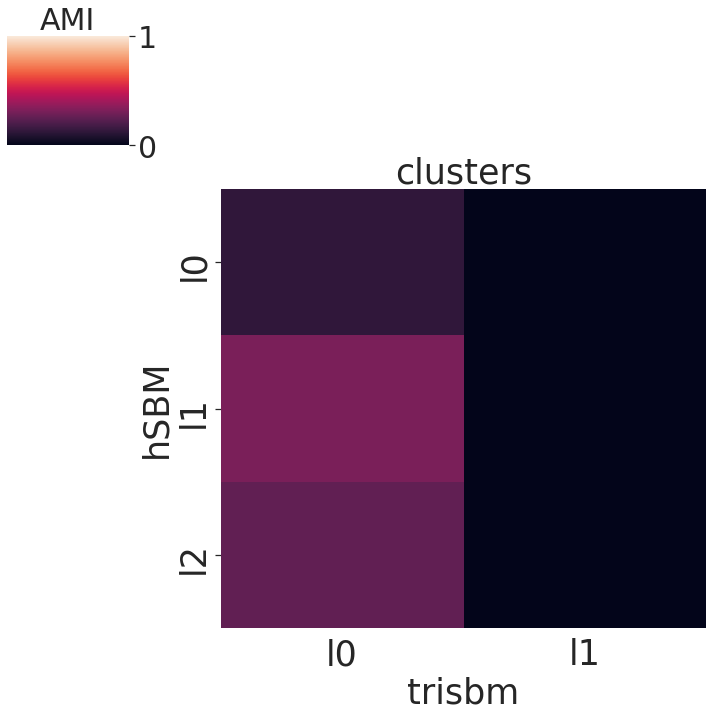

In [71]:
cm = sns.clustermap(AMI_levels,
            xticklabels=["l%d"%l for l in range(2)],
            yticklabels=["l%d"%l for l in range(3)],
            row_cluster=False,
            col_cluster=False,
            vmax=1)

ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_title("clusters", fontsize=35)
ax.set_ylabel("hSBM", fontsize=35, rotation=90)
ax.set_xlabel("trisbm", fontsize=35, rotation=0)

ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("AMI", fontsize=30)
plt.tight_layout()
fig.savefig("cluster_overlap_levels.pdf")

In [72]:
df_cluster_overlap = pd.DataFrame(index=df_first.columns, columns=df_second.columns, data=0.)

In [73]:
def get_overlap(x,y):
    return np.isin(x,y).sum().astype(float)/float(len(y))

def get_pval(setA, setB):
    x = np.isin(setA,setB).sum() # number of successes
    M = len(samples) # pop size
    k = len(setB) # successes in pop
    N = len(setA) # sample size
    pval = hypergeom.sf(x-1, M, k, N)
    return pval

In [74]:
for row in df_first.columns:
    for column in df_second.columns:
        df_cluster_overlap.at[row,column]=get_overlap(df_first[row].dropna().values, df_second[column].dropna().values)

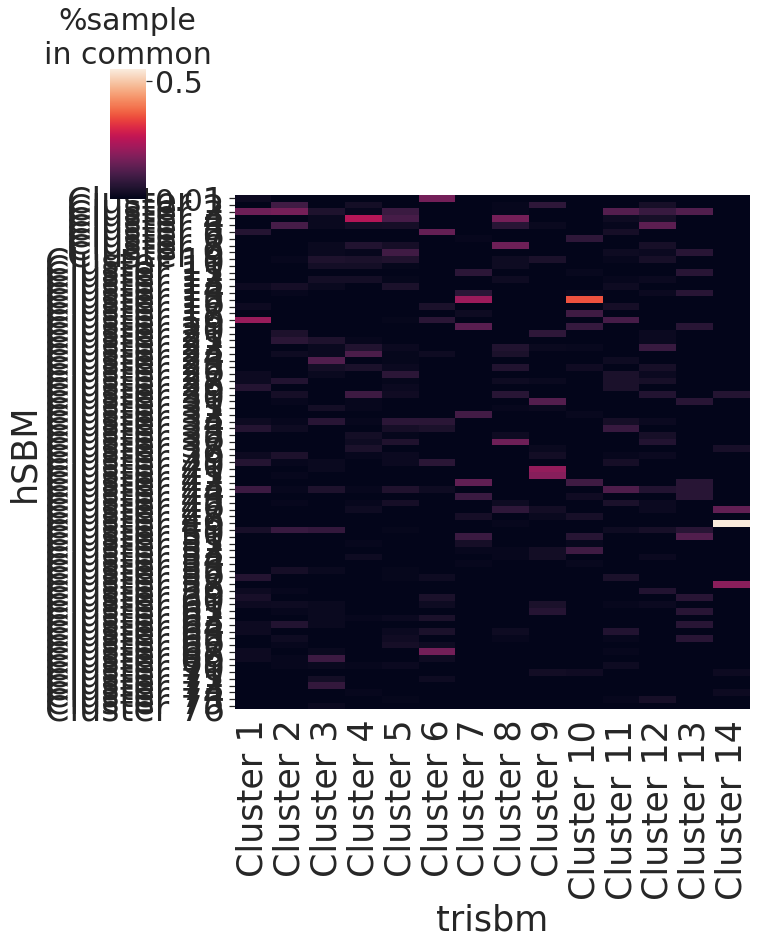

In [75]:
cm = sns.clustermap(df_cluster_overlap,
            xticklabels=df_second.columns,
            yticklabels=df_first.columns,
            row_cluster=False,
            col_cluster=False)

ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("hSBM", fontsize=35, rotation=90)
ax.set_xlabel("trisbm", fontsize=35, rotation=0)

ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("%sample\nin common", fontsize=30)
cm.savefig(f"topic_kl.pdf")

## Topic conservation

In [76]:
df_first = pd.read_csv("topsbm/topsbm_level_1_topics.csv")
df_second = pd.read_csv("trisbm/trisbm_level_0_topics.csv")
assert(np.isin(list(filter(lambda sample: str(sample)!="nan",df_first.values.ravel())), 
        list(filter(lambda sample: str(sample)!="nan",df_second.values.ravel())), invert=True).sum()==0)

In [77]:
genes = df_first.values.ravel()
genes = list(filter(lambda sample: str(sample)!="nan",genes))

In [78]:
partition = []
for sample in genes:
    partition.append((
        df_first.columns[(df_first==sample).any()].values[0].split(" ")[1],
        df_second.columns[(df_second==sample).any()].values[0].split(" ")[1]
        )
    )
partition = list(zip(*partition))

In [79]:
adjusted_mutual_info_score(partition[0], partition[1])

0.2523468826329563

In [80]:
AMI_levels = [[0.24, 0.099],
             [0.25,0.09],
             [0.12, 0.09]]

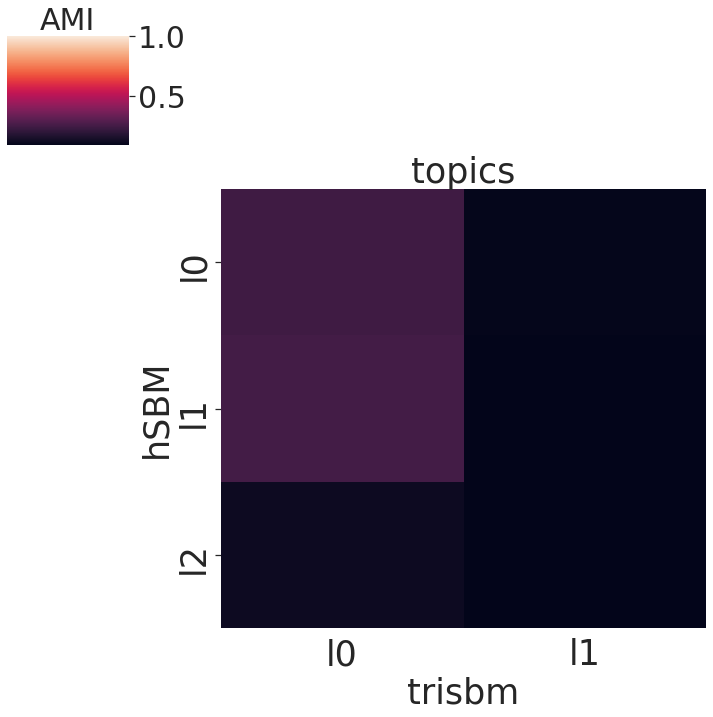

In [81]:
cm = sns.clustermap(AMI_levels,
            xticklabels=["l%d"%l for l in range(2)],
            yticklabels=["l%d"%l for l in range(3)],
            row_cluster=False,
            col_cluster=False,
            vmax=1)

ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_title("topics", fontsize=35)
ax.set_ylabel("hSBM", fontsize=35, rotation=90)
ax.set_xlabel("trisbm", fontsize=35, rotation=0)

ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("AMI", fontsize=30)
plt.tight_layout()
fig.savefig("topic_overlap_levels.pdf")

In [82]:
df_cluster_overlap = pd.DataFrame(index=df_first.columns, columns=df_second.columns, data=0.)

In [85]:
for row in df_first.columns:
    for column in df_second.columns:
        df_cluster_overlap.at[row,column]=get_overlap(df_first[row].dropna().values, df_second[column].dropna().values)

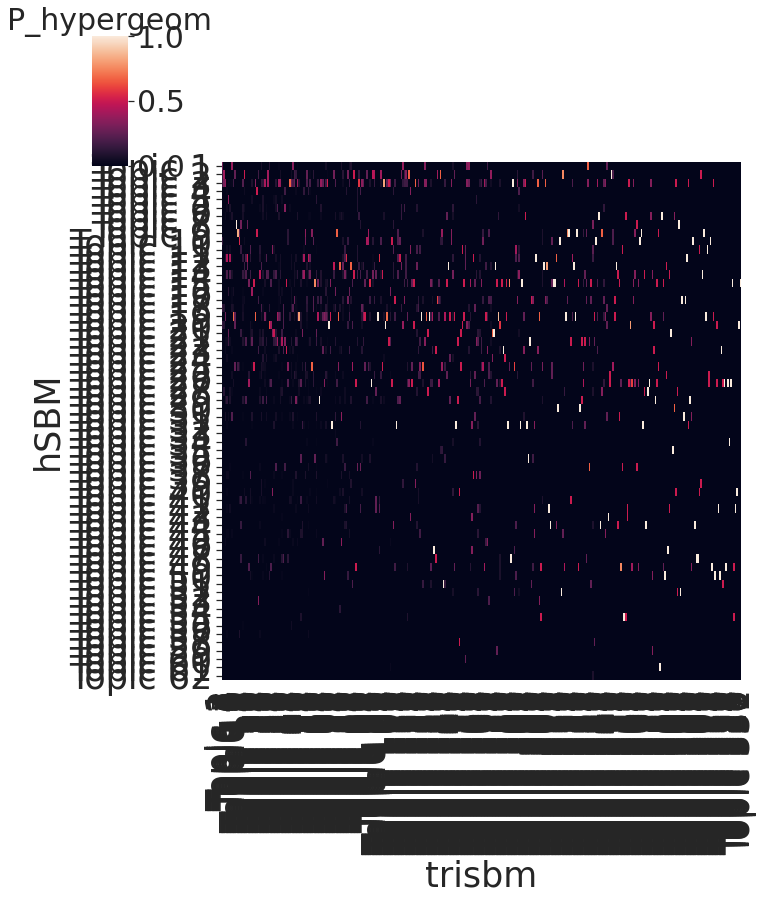

In [86]:
cm = sns.clustermap(df_cluster_overlap,
            xticklabels=df_second.columns,
            yticklabels=df_first.columns,
            row_cluster=False,
            col_cluster=False,
            vmax=1)

ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("hSBM", fontsize=35, rotation=90)
ax.set_xlabel("trisbm", fontsize=35, rotation=0)

ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
#cax.set_title("% gene in common", fontsize=30)
cax.set_title("P_hypergeom", fontsize=30)
cm.savefig(f"topic_overlap.pdf")

# Survival
See [triSBM_survival](triSBM_survival.ipynb)

# GO contribution
See [go_contribution](go_contribution.ipynb)